# Initial Dataset Predictions

### GDrive Setup
***- Only run if running on Google Colab***

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set directory to location of OULAD dataset in google drive

In [14]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'
/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [15]:
ls

anonymisedOUDataSet/  oulad_dataset_combined.csv
Deadline/             StudentAssessmentDaysDeadline.csv


## Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [17]:
if 'google.colab' in sys.modules:
  path = '../OULAD dataset'
else:
  path = '../../dataset'

In [18]:
assessments_df = pd.read_csv(f'{path}/anonymisedOUDataSet/assessments.csv')
courses_df = pd.read_csv(f'{path}/anonymisedOUDataSet/courses.csv')
student_assessments_df = pd.read_csv(f'{path}/anonymisedOUDataSet/studentAssessment.csv')
student_info_df = pd.read_csv(f'{path}/anonymisedOUDataSet/studentInfo.csv')
student_registration_df = pd.read_csv(f'{path}/anonymisedOUDataSet/studentRegistration.csv')
student_vle_df = pd.read_csv(f'{path}/anonymisedOUDataSet/studentVle.csv')
vle_df = pd.read_csv(f'{path}/anonymisedOUDataSet/vle.csv')

sns.set(rc={'figure.figsize':(11.7,8.27)})

### Join assessment data with individual student assessments

In [19]:
# drop columns not required to join with student_assessments_df
assessments_df.drop(['weight'], axis = 1, inplace = True)
assessments_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date
0,AAA,2013J,1752,TMA,19.0
1,AAA,2013J,1753,TMA,54.0
2,AAA,2013J,1754,TMA,117.0
3,AAA,2013J,1755,TMA,166.0
4,AAA,2013J,1756,TMA,215.0


In [20]:
# merge each student assessments with assessment data
combined_assessment = pd.merge(student_assessments_df,assessments_df,on='id_assessment')
combined_assessment.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
combined_assessment.head()

,id_assessment,id_student,score,code_module,code_presentation,assessment_type,date
0,1752,11391,78.0,AAA,2013J,TMA,19.0
1,1752,28400,70.0,AAA,2013J,TMA,19.0
2,1752,31604,72.0,AAA,2013J,TMA,19.0
3,1752,32885,69.0,AAA,2013J,TMA,19.0
4,1752,38053,79.0,AAA,2013J,TMA,19.0


In [21]:
# All assessments which are not the final exam
combined_assessment = combined_assessment[combined_assessment['assessment_type'] != 'Exam']

grouped_student_assessments = combined_assessment.groupby(['id_student','code_module','code_presentation']).mean()
grouped_student_assessments.drop(['id_assessment', 'date'],axis=1,inplace = True)

grouped_student_assessments.head()

score
id_student code_module code_presentation           
6516       AAA         2014J              61.800000
8462       DDD         2013J              87.666667
                       2014J              86.500000
11391      AAA         2013J              82.000000
23629      BBB         2013B              82.500000

#### Plot the number of modules each student takes

Text(0, 0.5, 'Number of students')

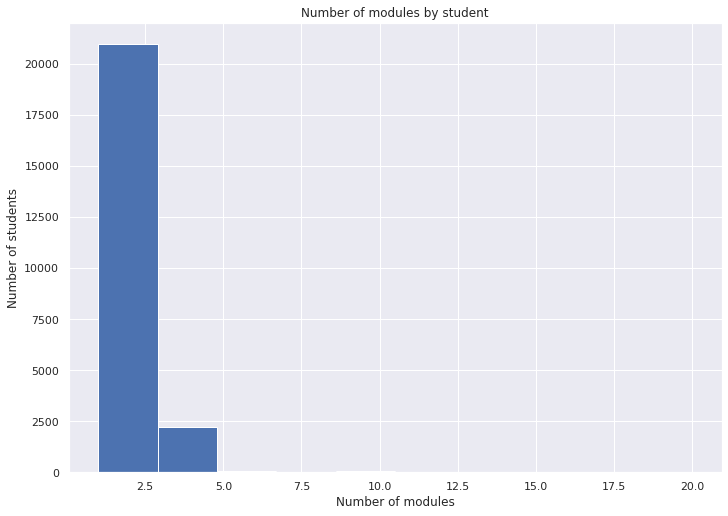

In [22]:
student_all_info = pd.merge(student_info_df,grouped_student_assessments,on='id_student')
fig1 = student_all_info.groupby(['id_student']).code_module.count().sort_values().hist()
fig1.set_title('Number of modules by student')
fig1.set_xlabel('Number of modules')
fig1.set_ylabel('Number of students')

#### Number of sum clicks per student

In [23]:
# click data
def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

clicks = inner_merge(student_vle_df,
                      vle_df,
                      ['id_site','code_module','code_presentation','activity_type'],
                      ['id_site','code_module','code_presentation'],
                    )

clicks = clicks.drop(['id_site','date'], axis = 1)

clicks = clicks.groupby(['code_module','code_presentation','id_student','activity_type']).sum().reset_index()

grouped_vle_sum_clicks_activity = pd.pivot_table(data = clicks, 
                            index = ['code_module','code_presentation','id_student'],
                            columns = 'activity_type', 
                            values = ['sum_click'],
                            fill_value = 0,
                            ).reset_index()

# get rid of multi index
grouped_vle_sum_clicks_activity = pd.concat([grouped_vle_sum_clicks_activity['code_module'],
                              grouped_vle_sum_clicks_activity['code_presentation'],
                              grouped_vle_sum_clicks_activity['id_student'], 
                              grouped_vle_sum_clicks_activity['sum_click']], axis=1)

temp = grouped_vle_sum_clicks_activity.groupby(['code_module','code_presentation','id_student']).sum(numeric_only=True, min_count=0)


In [24]:
temp2 = pd.DataFrame()
temp2['sum_click'] = temp.sum(axis=1)

In [25]:
grouped_vle_sum_clicks_activity = pd.merge(grouped_vle_sum_clicks_activity,temp2,on = ['id_student','code_module','code_presentation'],how='left')

In [26]:
grouped_vle_sum_clicks_activity.head()

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,0,0,0,0,181,0,138,0,0,553,0,0,0,0,0,0,13,0,32,5,922
1,AAA,2013J,28400,10,0,0,0,393,0,324,0,0,535,0,0,0,0,0,0,12,0,87,48,1409
2,AAA,2013J,30268,0,0,0,0,105,0,59,0,0,66,0,0,0,0,0,0,4,0,22,4,260
3,AAA,2013J,31604,2,0,0,0,502,1,432,0,0,817,0,0,0,0,0,0,19,0,144,90,2007
4,AAA,2013J,32885,0,0,0,0,175,4,204,0,0,491,0,0,0,0,0,0,45,0,79,14,1012


In [27]:
# merge grouped_vle_sum_clicks_activity to student_all_info to a new dataframe called df
df = pd.merge(student_all_info,grouped_vle_sum_clicks_activity,on = ['id_student','code_module','code_presentation'],how='left')

In [28]:
# remove rows with null
df.dropna(inplace=True)

In [29]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0


In [30]:
df.final_result

0               Pass
1               Pass
2               Pass
3               Pass
4               Pass
            ...     
32013    Distinction
32014    Distinction
32015           Pass
32016      Withdrawn
32017    Distinction
Name: final_result, Length: 30244, dtype: object

In [31]:
# replace final result string with numerical representation
df.final_result = df.final_result.replace({'Withdrawn':0,'Fail':1,'Pass':2,'Distinction':3})

### Module AAA - statistics

In [32]:
# select every 
module_AAA = df.loc[df['code_module'] == "AAA"]
print(module_AAA.shape)

# remove withdrawn
module_AAA = module_AAA[module_AAA.final_result != 0]

# 2 results - pass or fail
module_AAA['final_result'] = module_AAA['final_result'].replace({1:0, 2:1, 3:1})
module_AAA.shape

(740, 34)


(618, 34)

In [33]:
module_AAA.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0


In [34]:
#students who completed the module >=1 are included
module_AAA.groupby('id_student',as_index=False).size().sort_values(by='size')

,id_student,size
0,6516,1
384,958987,1
385,968578,1
386,971027,1
387,978739,1
...,...,...
547,2596621,2
36,94961,2
290,390890,2
400,1472925,4


In [35]:
# split students by pass or fail
module_AAA_fail = module_AAA.loc[module_AAA['final_result'] == 0]
module_AAA_pass = module_AAA.loc[module_AAA['final_result'] == 1]

#### Plot distribution of sum clicks by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of sum clicks by pass and fail')

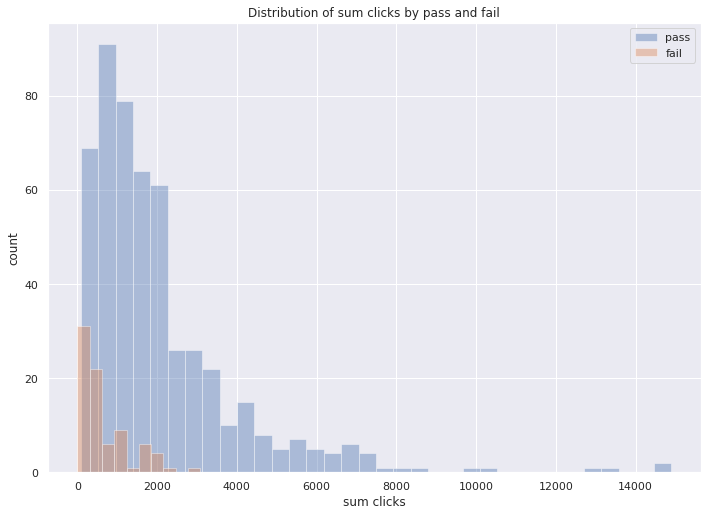

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(module_AAA_pass.groupby(['id_student'])['sum_click'].sum(), kde=False)
sns.distplot(module_AAA_fail.groupby(['id_student'])['sum_click'].sum(), kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("sum clicks")
plt.ylabel("count")

plt.title("Distribution of sum clicks by pass and fail")

#### Plot distribution of assessment scores by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of assessment scores by pass and fail')

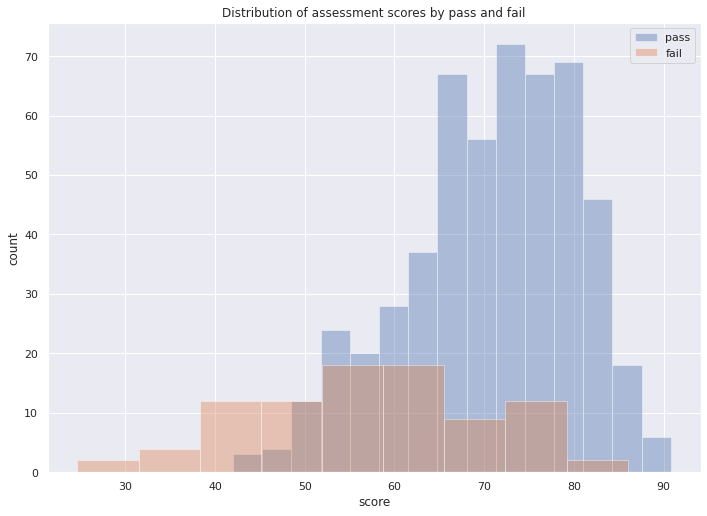

In [37]:
sns.distplot(module_AAA_pass["score"],kde=False)
sns.distplot(module_AAA_fail["score"],kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("score")
plt.ylabel("count")

plt.title("Distribution of assessment scores by pass and fail")

#### Plot final result by gender

In [38]:
gender_temp = []
final_result_temp = []

for i in list(module_AAA.groupby('id_student')['gender']):
  gender_temp.append(i[1].unique()[0])
  
for i in list(module_AAA.groupby('id_student')['final_result']):
  final_result_temp.append(i[1].unique()[0])

gender_temp = pd.DataFrame(gender_temp, columns=['gender'])
final_result_temp = pd.DataFrame(final_result_temp, columns=['final_result'])

In [39]:
joined_gender_results = gender_temp.join(final_result_temp)

Text(0, 0.5, 'Count')

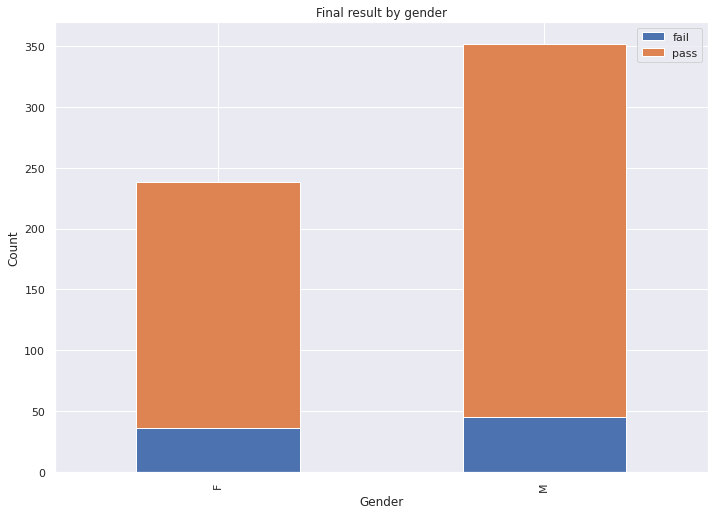

In [40]:
pd.crosstab(joined_gender_results['gender'],joined_gender_results['final_result']).plot.bar(stacked=True)
plt.title("Final result by gender")

plt.legend(labels=['fail','pass'])

plt.xlabel("Gender")
plt.ylabel("Count")

### Predictions

#### Evaluation

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score


def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision_macro = precision_score(true_labels, predictions, average='macro')
  precision_weighted = precision_score(true_labels, predictions, average='weighted')

  recall = recall_score(true_labels, predictions, average='macro')
  accuracy = accuracy_score(true_labels, predictions)
  f1 = fbeta_score(true_labels, predictions, beta=1, average='macro')

  print("Classifier '%s' has Acc=%0.3f P_macro=%0.3f P_weighted=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision_macro,precision_weighted,recall,f1))
  # Specify three digits instead of the default two.
  print(classification_report(true_labels, predictions, digits=3))
  print('\nConfusion matrix:\n') # Note the order here is true, predicted, odd.
  cm = confusion_matrix(true_labels, predictions)
  labels = np.unique(true_labels)
  print(pd.DataFrame(cm, index=labels, columns=labels))

  plt.subplots(figsize=(8,7))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu")

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(['fail', 'pass'])
  ax.yaxis.set_ticklabels(['fail', 'pass'])

#### Split dataset

In [42]:
from sklearn.model_selection import train_test_split

def split_dataset(X, Y):   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    return X_train, Y_train, X_test, Y_test

#### Prepare data

In [43]:
from sklearn import preprocessing

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


class MultiColumnOHEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [44]:
# categorise df columns
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

from sklearn.pipeline import Pipeline

encoding_pipeline = Pipeline([
    ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
])
df = encoding_pipeline.fit_transform(df)

In [45]:
# remove withdrawl
df = df[df.final_result != 0]
Y = df['final_result'].replace({1:0, 2:1, 3:1}) # Fail; Pass, Distinction -> Incomplete; Complete
X = df.drop('final_result', axis=1)

# Convert categorical variable into indicator variables. One-hot encoding
X = pd.get_dummies(X)

In [46]:
X.head()

,id_student,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y
0,11391,1,9,2,0,240,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,28400,1,2,1,0,60,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,31604,0,5,1,0,60,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,32885,2,5,0,0,60,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,38053,0,8,1,0,60,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [47]:
X_train, Y_train, X_test, Y_test = split_dataset(X,Y)

#### Dummy Classifier

Evaluation for: Dummy Classifier test dataset
Classifier 'Dummy Classifier test dataset' has Acc=0.717 P_macro=0.358 P_weighted=0.514 R=0.500 F1=0.418
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1671
           1      0.717     1.000     0.835      4230

    accuracy                          0.717      5901
   macro avg      0.358     0.500     0.418      5901
weighted avg      0.514     0.717     0.599      5901


Confusion matrix:

   0     1
0  0  1671
1  0  4230


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr

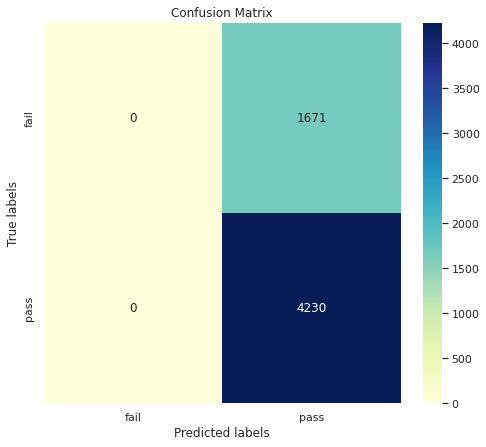

In [48]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, Y_train)

test_dt_predictions = dummy_classifier.predict(X_test)

evaluation_summary("Dummy Classifier test dataset",  test_dt_predictions, Y_test)

#### Decision Tree Classifier

Evaluation for: Decision Tree Classifier test dataset
Classifier 'Decision Tree Classifier test dataset' has Acc=0.808 P_macro=0.764 P_weighted=0.808 R=0.764 F1=0.764
              precision    recall  f1-score   support

           0      0.661     0.662     0.661      1671
           1      0.866     0.866     0.866      4230

    accuracy                          0.808      5901
   macro avg      0.764     0.764     0.764      5901
weighted avg      0.808     0.808     0.808      5901


Confusion matrix:

      0     1
0  1106   565
1   567  3663


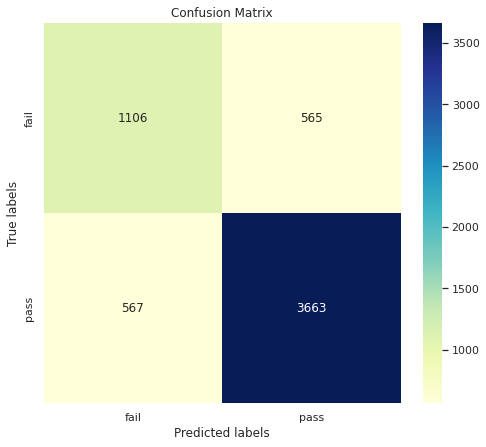

In [49]:
from sklearn.tree import DecisionTreeClassifier 

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

test_dt_predictions = dt_classifier.predict( X_test)

evaluation_summary("Decision Tree Classifier test dataset",  test_dt_predictions, Y_test)

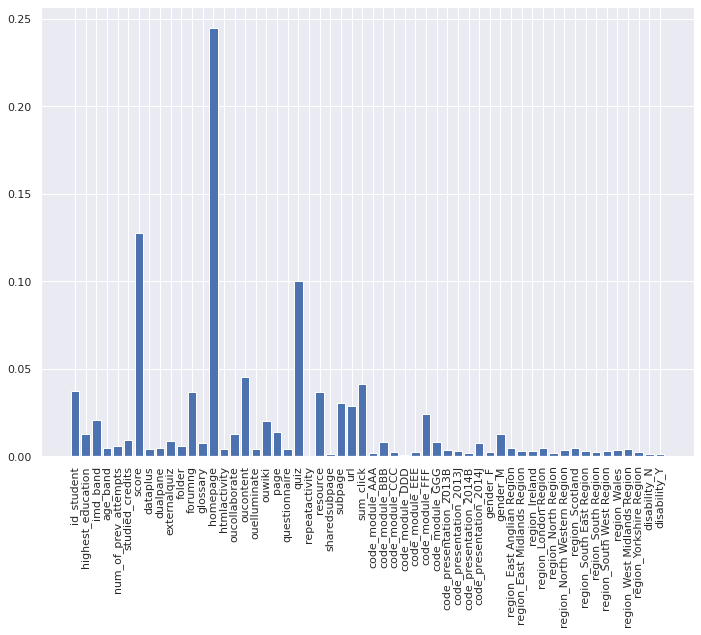

In [50]:
feature_names = dt_classifier.feature_names_in_

# get importance
importance = dt_classifier.feature_importances_

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

### Guassian NB

Evaluation for: Gaussian NB Classifier test dataset
Classifier 'Gaussian NB Classifier test dataset' has Acc=0.546 P_macro=0.652 P_weighted=0.772 R=0.659 F1=0.545
              precision    recall  f1-score   support

           0      0.376     0.922     0.535      1671
           1      0.928     0.397     0.556      4230

    accuracy                          0.546      5901
   macro avg      0.652     0.659     0.545      5901
weighted avg      0.772     0.546     0.550      5901


Confusion matrix:

      0     1
0  1540   131
1  2551  1679


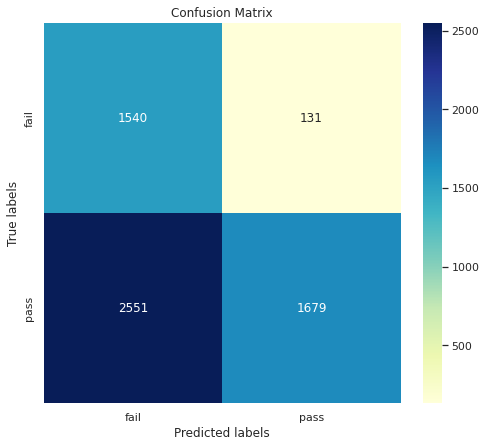

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)

test_gnb_predictions = gnb.predict( X_test)

evaluation_summary("Gaussian NB Classifier test dataset",  test_gnb_predictions, Y_test)

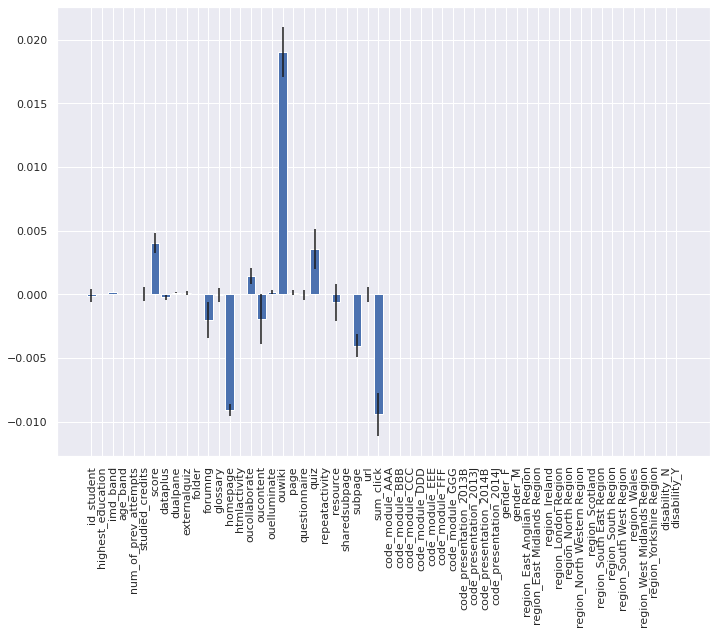

In [52]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(gnb, X_test, Y_test)

feature_names = gnb.feature_names_in_

plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

#### Random Forest

Evaluation for: Gaussian NB Classifier test dataset
Classifier 'Gaussian NB Classifier test dataset' has Acc=0.873 P_macro=0.873 P_weighted=0.873 R=0.804 F1=0.828
              precision    recall  f1-score   support

           0      0.873     0.644     0.741      1671
           1      0.873     0.963     0.916      4230

    accuracy                          0.873      5901
   macro avg      0.873     0.804     0.828      5901
weighted avg      0.873     0.873     0.866      5901


Confusion matrix:

      0     1
0  1076   595
1   156  4074


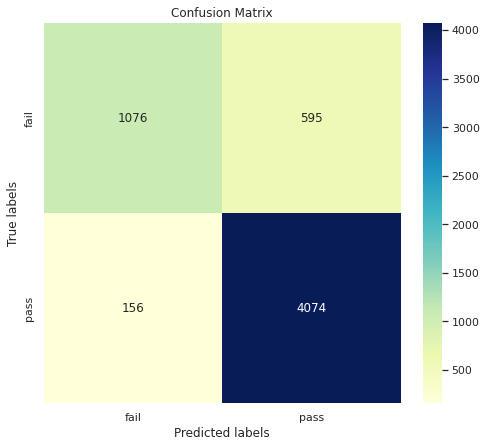

In [53]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_estimators = 200,
                             max_features = 'sqrt', 
                             min_samples_split = 10, 
                            )

randomforest.fit(X_train, Y_train)

test_randomforest_predictions = randomforest.predict( X_test)

evaluation_summary("Gaussian NB Classifier test dataset",  test_randomforest_predictions, Y_test)

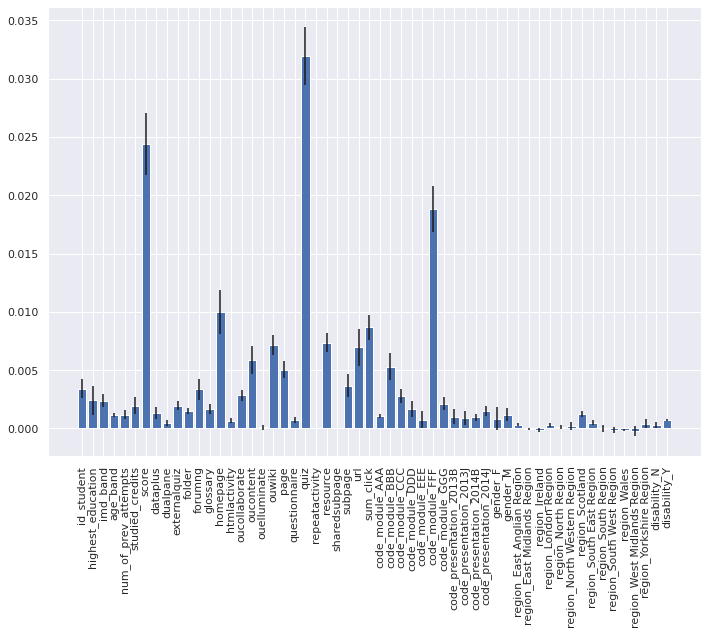

,importance,column
21,0.031927,quiz
6,0.024369,score
33,0.018810,code_module_FFF
13,0.009998,homepage
27,0.008676,sum_click
23,0.007355,resource
18,0.007151,ouwiki
26,0.006948,url
16,0.005863,oucontent
29,0.005287,code_module_BBB


In [54]:
importance = permutation_importance(randomforest, X_test, Y_test)

feature_names = randomforest.feature_names_in_

plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

importance_table = pd.DataFrame({'importance': importance['importances_mean'],
                                 'column': feature_names })
importance_table.sort_values(by = 'importance', ascending = False)[:20]

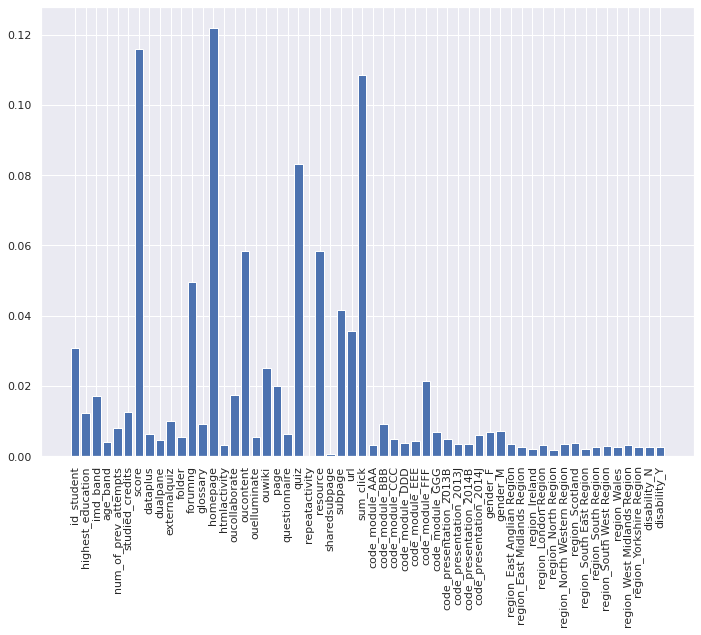

,importance,column
13,0.121808,homepage
6,0.115795,score
27,0.108572,sum_click
21,0.083161,quiz
23,0.058446,resource
16,0.058384,oucontent
11,0.049530,forumng
25,0.041541,subpage
26,0.035706,url
0,0.030812,id_student


In [55]:
importance = randomforest.feature_importances_

feature_names = randomforest.feature_names_in_

plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

importance_table = pd.DataFrame({'importance': importance,
                                 'column': feature_names })
importance_table.sort_values(by = 'importance', ascending = False)[:20]